In [1]:
import os
import cv2
import pandas as pd
import numpy as np
def onehotc(masks):
    code_mask = []
    for mask in masks:
        nw = list(mask.shape)[:2]
        nw.append(2)
        # print(tuple(nw))
        code = np.zeros(tuple(nw))
        code[:,:,0] = np.array(mask==0, dtype= np.int8)
        code[:,:,1] = np.array(mask==1, dtype= np.int8)

        code_mask.append(code)
    code_mask = np.array(code_mask, dtype= np.int8)
    print(code_mask.shape)
    return code_mask


def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

class loadDataset:
    def __init__(self, csv_file) -> None:
        self.data = pd.read_csv(csv_file)
        print(f"len : {len(self.data)}")
    def getDataset(self, k = 1.0):
        a = []
        b = []
        mx = len(self.data)
        for idx in range(int(mx*k)):
            print(f"Load {idx+1}/{mx} : {((idx+1)/mx)*100:3.2f}%", end="\r" if mx-1 != idx else "\n")
            img_path = self.data.iloc[idx, 1]
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_rle = self.data.iloc[idx, 2]
            mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
            a.append(cv2.resize(np.array(image), (224,224)))
            # a.append(np.array(image))
            b.append(np.round(cv2.resize(np.array(mask), (224,224))))
            # b.append(np.array(mask)[::2,::2])
            # b.append(np.array(mask, dtype=np.int8))
        print("finish")
        
        return np.array(a), np.array(b)

In [2]:
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plot
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, Normalization, concatenate, Flatten, Dense, Reshape


In [3]:

def Double(conv, unit):
    conv0 = Conv2D(unit, (3, 3), activation='relu', padding='same')(conv)
    conv0 = Dropout(0.2)(conv0)
    conv0 = Conv2D(unit, (3, 3), activation='relu', padding='same')(conv0)
    pool0 = MaxPooling2D((2, 2))(conv0)
    return conv0, pool0

def doubleUp(conv, unit, plus:list):
    # up1 = UpSampling2D()(conv)
    up1 = Conv2DTranspose(unit, (2, 2), strides=2, padding="same")(conv)
    plus.insert(0, up1)
    up1 = concatenate(plus, axis=-1)
    conv4 = Conv2D(unit, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(unit, (3, 3), activation='relu', padding='same')(conv4)
    return conv4
def downshift(conv, p = (2,2)):
    return MaxPooling2D(p)(conv)

def unet_model(output_channels: int):

    img_input = Input(shape=(224,224, 3))
    # img_input = Normalization()(img_input)

    conv01, pool01 = Double(img_input, 64)
    conv0, pool0 = Double(pool01, 128)
    conv1, pool1 = Double(pool0, 256)
    conv2, pool2 = Double(pool1, 512)

    conv3 = Conv2D(1024,(3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv3)
    
    conv4 = doubleUp(conv3, 512, [conv2, downshift(conv1)])
    conv5 = doubleUp(conv4, 256, [conv1, downshift(conv0)])
    conv6 = doubleUp(conv5, 128, [conv0,downshift(conv01)])
    conv7 = doubleUp(conv6, 64, [conv01])

    out = Conv2D(output_channels, (2, 2), activation='sigmoid', padding='same')(conv7)

    model = Model(img_input, out)
    return model

model = unet_model(1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [4]:
from keras.losses import binary_crossentropy

In [5]:
# class TverskyLoss(tf.keras.losses.Loss):
#     """
#     Tversky Loss

#     Args:
#         alpha: Weight for the true positive term.
#         beta: Weight for the false positive term.
#     """

#     def __init__(self, alpha=0.5, beta=0.5):
#         super(TverskyLoss, self).__init__(name='tversky')
#         self.alpha = alpha
#         self.beta = beta

#     def call(self, y_true, y_pred):
#         """
#         Calculates the Tversky Loss.

#         Args:
#         y_true: Ground truth labels.
#         y_pred: Predicted labels.

#         Returns:
#         Tversky Loss.
#         """

#         y_true = tf.cast(y_true, y_pred.dtype)
#         epsilon = 1e-12

#         # Calculate the intersection over union.
#         iou = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) / (
#         tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - iou + epsilon)

#         # Calculate the Tversky Loss.
#         loss = (self.alpha * (1 - iou)**self.beta + (1 - self.alpha) * iou)**(1 / self.beta)

#         return loss

In [5]:
class DiceBCELoss(tf.keras.losses.Loss):
    def __init__(self, weight=None, from_logits=False, smooth=1e-7, reduction=tf.keras.losses.Reduction.NONE, name=None):
        super(DiceBCELoss, self).__init__(reduction=reduction, name=name)
        self.from_logits = from_logits
        self.smooth = smooth
        self.bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=self.from_logits, reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        bce_loss = self.bce_loss(y_true, y_pred)
        
        y_pred = tf.sigmoid(y_pred)
        intersection = tf.reduce_sum(y_pred * y_true)
        dice_loss = 1 - (2.0 * intersection + self.smooth) / (tf.reduce_sum(y_pred) + tf.reduce_sum(y_true) + self.smooth)

        # BCE Loss와 Dice Loss의 가중 평균
        dice_bce_loss = bce_loss + dice_loss

        return dice_bce_loss


In [7]:
# class DiceBCELoss(tf.keras.losses.Loss):
#     def __init__(self, weight=None, from_logits=False, smooth=1e-7):
#         super(DiceBCELoss, self).__init__()
#         self.from_logits = from_logits
#         self.smooth = smooth
#         self.bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=self.from_logits)

#     def call(self, y_true, y_pred):
#         bce_loss = self.bce_loss(y_true, y_pred)
        
#         y_pred = tf.sigmoid(y_pred)
#         intersection = tf.reduce_sum(y_pred * y_true)
#         dice_loss = 1 - (2.0 * intersection + self.smooth) / (tf.reduce_sum(y_pred) + tf.reduce_sum(y_true) + self.smooth)

#         # BCE Loss와 Dice Loss의 가중 평균
#         dice_bce_loss = bce_loss + dice_loss

#         return dice_bce_loss

In [6]:
datatset = loadDataset('train.csv').getDataset()
Xtran, Xtest = datatset[0][:7100], datatset[0][7100:]
# datatset = onehotc(datatset[1])
datatset = datatset[1]
datatset = np.expand_dims(datatset,axis=-1)
Ytran, Ytest = datatset[:7100], datatset[7100:]
print(len(Ytran))

len : 7140
Load 7140/7140 : 100.00%
finish
7100


In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
# ImageDataGenerator 객체 생성
data_gen_args = dict(
    rotation_range=20,       # 이미지 회전 범위 설정 (0-180)
    width_shift_range=0.1,   # 이미지 가로 이동 범위 설정 (전체 너비의 비율)
    height_shift_range=0.1,  # 이미지 세로 이동 범위 설정 (전체 높이의 비율)
    shear_range=0.2,         # 전단 강도 설정
    zoom_range=0.5,          # 확대/축소 범위 설정
    horizontal_flip=True,    # 수평 뒤집기 설정
    vertical_flip=True,      # 수직 뒤집기 설정
    fill_mode='reflect'      # 새롭게 생성된 픽셀을 채우는 방식
)

# 이미지 및 마스크 데이터 로드
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# 데이터 시각화 (원본 이미지와 증강된 이미지 비교)
XtranP = []
YtranP = []
for i in range(len(Xtran)):
    seed = np.random.randint(9999)
    augmented_image = image_datagen.random_transform(Xtran[i], seed=seed)
    augmented_mask = mask_datagen.random_transform(Ytran[i], seed=seed)
    XtranP.append(augmented_image)
    YtranP.append(np.round(augmented_mask))
    

In [9]:
np.max(Ytran)

Xtran = np.concatenate((Xtran, np.array(XtranP)), axis=0)
Ytran = np.concatenate((Ytran, np.array(YtranP)), axis=0)
XtranP = None
YtranP = None

In [10]:
# class DiceLoss(tf.keras.losses.Loss):
#     def __init__(self, smooth=1e-6, gama=2, reduction=tf.keras.losses.Reduction.AUTO, name="Dice_loss"):
#         super(DiceLoss, self).__init__(reduction=reduction, name=name)
#         self.name = name
#         self.smooth = smooth
#         self.gama = gama

#     def call(self, y_true, y_pred):
#         y_true, y_pred = tf.cast(
#             y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
#         nominator = 2 * \
#             tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
#         denominator = tf.reduce_sum(
#             y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
#         result = 1 - tf.divide(nominator, denominator)
#         return result

In [11]:
# model = tf.keras.models.load_model('20230703_ver4.h5')

In [12]:
# model = tf.keras.models.load_model("20230703_ver_4__0.h5", custom_objects={"DiceLoss": DiceLoss})

In [13]:

# print(Xtran.shape, Ytran.shape)
# print(Xtest.shape, Ytest.shape)

# model.predict(Xtran[:1])

# model.compile(optimizer='adam', loss=TverskyLoss(), metrics=[binary_crossentropy])


In [13]:

print(Xtran.shape, Ytran.shape)
print(Xtest.shape, Ytest.shape)

# model.predict(Xtran[:1])


(14200, 224, 224, 3) (14200, 224, 224, 1)
(40, 224, 224, 3) (40, 224, 224, 1)


In [11]:
# model.compile(optimizer=tf.optimizers.Adam(), loss="DiceLoss", metrics=['accuracy'])
# model.compile(optimizer=tf.optimizers.Adam(), loss=DiceLoss(), metrics=['accuracy'])

# model.compile(optimizer=tf.optimizers.Adam(0.0001), loss=tf.losses.BinaryFocalCrossentropy(), metrics=['accuracy', binary_crossentropy])
model.compile(optimizer=tf.optimizers.Adam(0.001), loss=DiceBCELoss(), metrics=['accuracy', binary_crossentropy])

In [14]:
Xtran = Xtran.astype('float32')
Ytran = Ytran.astype('float32')

Xtest = Xtest.astype('float32')
Ytest = Ytest.astype('float32')

with tf.device("GPU:0"):
    for i in range(1):
        history = model.fit(Xtran, Ytran, batch_size=5, epochs=10, validation_data=(Xtest,Ytest))
        model.save(f"20230703_ver_9__{i}.h5")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [17]:
# model = tf.keras.models.load_model("20230703_ver_8__0.h5", custom_objects={"DiceBCELoss": DiceBCELoss})

(224, 224, 1)
1/1 [==============================] - 0s 133ms/step
1.2936026e-11
(224, 224, 1)
(224, 224, 3)


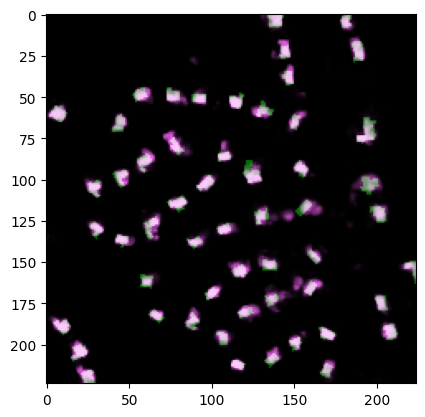

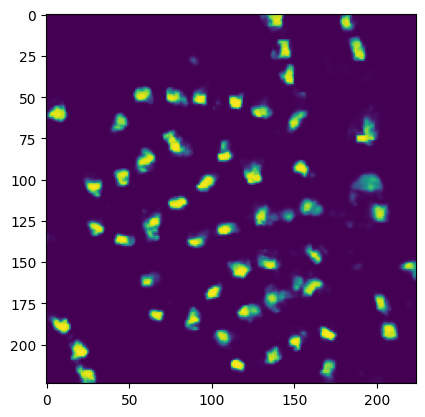

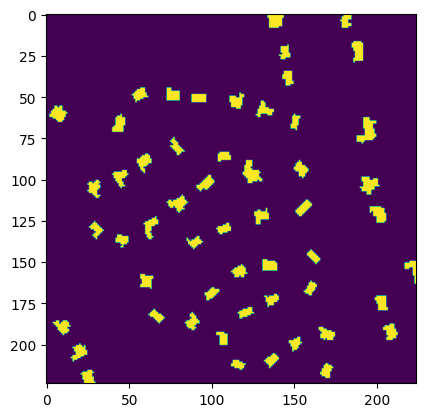

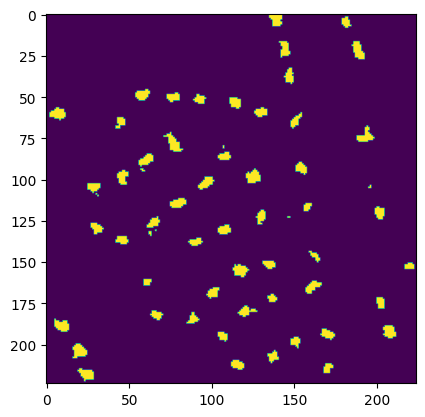

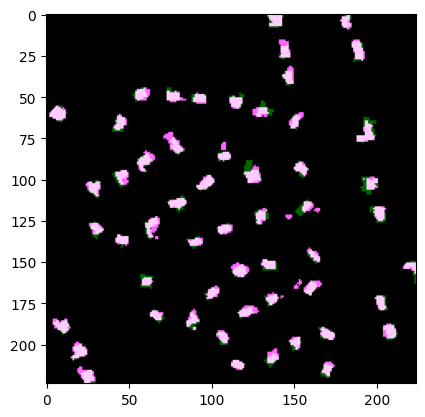

In [18]:
codef = 18
a = Xtest[codef:codef+1]
b = Ytest[codef:codef+1]
# print(model.predict(a)[0].shape)
print(b[0].shape)

hj = model.predict(a)[0]
print(np.min(hj))
# hj = np.argmax(model.predict(a)[0], axis=-1)
print(hj.shape)
cb = np.zeros((224,224,3))
cb[:,:,1] = ((b[0].reshape(224,224)) + hj.reshape(224,224)) /2.5
# cb[:,:,1] = ((b[0][:,:,0]) + hj) /2.5
cb[:,:,0] = hj.reshape(224,224)
cb[:,:,2] = hj.reshape(224,224)

cb1 = np.zeros((224,224,3))
cb1[:,:,1] = ((b[0].reshape(224,224)) + np.round(hj).reshape(224,224)) /2.5
# cb[:,:,1] = ((b[0][:,:,0]) + hj) /2.5
cb1[:,:,0] = np.round(hj).reshape(224,224)
cb1[:,:,2] = np.round(hj).reshape(224,224)
# plot.imshow(model.predict(a)[0])
# plot.imshow(np.argmax(model.predict(a)[0], axis=-1))
print(cb.shape)
plot.figure(1)
plot.imshow(cb)
plot.figure(2)
plot.imshow(hj)
plot.figure(3)
plot.imshow(b[0])
plot.figure(4)
plot.imshow(hj>0.7)
plot.figure(5)
plot.imshow(cb1)
plot.show()

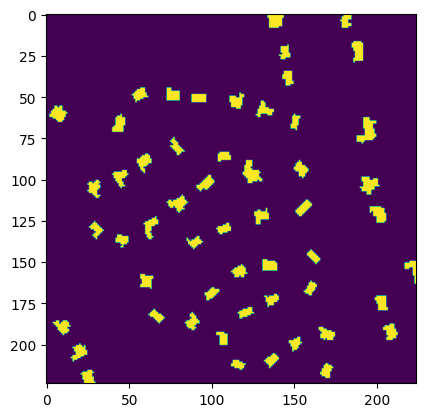

[0]
[0. 1.]


In [19]:
plot.imshow(b[0])
plot.show()
np.max(b)
np.max(np.argmax(b, axis=-1))
print(np.unique(np.argmax(b, axis=-1)))
print(np.unique(b))



In [20]:
# codef = 0
# a = Xtest
# b = Ytest
# DiceLoss()(b,model.predict(a))

In [21]:

# RLE 인코딩 함수
import csv
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


class ScoreData:
    def __init__(self, csv_file) -> None:
        self.data = pd.read_csv(csv_file)
        print(f"len : {len(self.data)}")
        
    def PredictData2CSV(self, model, k = 1.0, filen = 'cv5.csv'):
        with open(filen, 'w', newline='') as f:
            writer = csv.writer(f)
            data = ['img_id','mask_rle']
            writer.writerow(data)
            a = []
            mx = len(self.data)
            for idx in range(int(mx*k)):
                a=[]
                print(f"Load {idx+1}/{mx} : {((idx+1)/mx)*100:3.2f}%", end="\r" if mx-1 != idx else "\n")
                img_path = self.data.iloc[idx, 1]
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                a.append(self.data.iloc[idx, 0])
                b = rle_encode(np.round(model.predict(np.array([image]), verbose=0)[0]))
                # b = rle_encode(np.round(np.argmax(model.predict(np.array([image]), verbose=0)[0], axis=-1)))
                # print(np.max(model.predict(np.array([image]), verbose=0)[0]))
                # print(np.unique(np.round(model.predict(np.array([image]), verbose=0)[0])))
                a.append(b if b != '' else '-1')
                writer.writerow(a)

        print("finish")

kl = ScoreData("./test.csv")
test = kl.PredictData2CSV(model= model, k = 1.0, filen= "Nuclear.csv")

len : 60640


KeyboardInterrupt: 

In [ ]:

    # sk3 = UpSampling2D()(conv3)
    # sk3 = UpSampling2D()(sk3)


    # conv4 = doubleUp(conv3, 512, [conv2, downshift(conv1)])

    # sk4 = UpSampling2D()(conv4)
    # sk4 = UpSampling2D()(sk4)

    # conv5 = doubleUp(conv4, 256, [conv1, downshift(conv0), sk3])

    # sk5 = UpSampling2D()(conv5)
    # sk5 = UpSampling2D()(sk5)
    # sk3 = UpSampling2D()(sk3)

    # conv6 = doubleUp(conv5, 128, [conv0, downshift(conv01), sk3, sk4])

    # sk3 = UpSampling2D()(sk3)
    # sk4 = UpSampling2D()(sk4)

    # conv7 = doubleUp(conv6, 64, [conv01, sk3, sk4, sk5])

    # out = Conv2D(output_channels, (2, 2), activation='softmax', padding='same')(conv7)
